In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lmfit

from lmfit import Parameters, minimize, report_fit

import numpy as np

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def bound_roi(im : np.ndarray, mx = tuple, size : int = 200):
    """im : image in grayscale
       mx : tuple with the argmax of the im matrix
       size : 1/2*max size of the roi
       if size > mx: take bound to be 0 or im.shape[]"""
    bounds_roi = []
    for m in mx:
        if 0 < m - size:
            bounds_roi.append(m - size)
        else: bounds_roi.append(0)
        if m + size < im.shape[0]:
            bounds_roi.append(m + size)
        else: bounds_roi.append(im.shape[0])
    return bounds_roi

def guess_centroid(im : np.ndarray):
    return np.unravel_index(im.argmax(), im.shape)

def select_roi(im : np.ndarray, bounds : list) -> np.ndarray:
    return im[bounds[0] : bounds[1], bounds[2] : bounds[3]]

def plot_fit_result(im : np.ndarray, p0 : list, ax = None):
    """Plot gaussian center (p0[1], p0[2]) as a cross
    and a circle of radius p0[3]"""
    if ax == None : ax = plt.gca()
    pl = ax.imshow(im)#, cmap=plt.get_cmap('gray'))
    cross = ax.scatter(x=p0[1], y=p0[2], marker='x',
     color='r', label = '(%.1f, %.1f)' %(p0[1], p0[2]))

    circle = plt.Circle((p0[1], p0[2]), radius=p0[3], color='r', lw=1, fill=False,
     label = '$(\sigma_x, \sigma_y) = $ (%.1f, %.1f)' %(p0[3], p0[4]))
    ax.add_artist(circle)
    ax.legend([cross], ['(%.1f, %.1f)' %(p0[1], p0[2])])

In [4]:
def fitGauss2d(im : np.ndarray, p0 : list, mode: str = 'waist'):
    """Fit to 2D gaussian.
        mode: str = ['waist', 'ind']
            'waist': single sigma for r -> 2*r^2/w^2
            'ind': independent sigma for x/y -> 2*[ (x/sig_x)**2 + (y/sig_y)**2]
        p0: initial guess of parameters:
            [I0, x0, y0, w] for 'waist' mode
            [I0, x0, y0, sigma_x, sigma_y] for 'ind' mode 
    """
    
    x = np.arange(0, im.shape[1], 1)
    y = np.arange(0, im.shape[0], 1)

    xx, yy = np.meshgrid(x , y)

    def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y, offset):
        """Gaussian beam intensity, 2 sigma parametrization"""
        return np.exp(-2.0*(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)) + offset
    
    def gaussian2DWaist(x, y, cen_x, cen_y, w, offset):
        """Gaussian beam intensity, waist parametrization"""
        return np.exp(-2.0*((cen_x-x)**2 + (cen_y-y)**2)/w**2) + offset

    def residuals(p, x, y, z, mode: str = mode):
        height = p["height"].value
        cen_x = p["centroid_x"].value
        cen_y = p["centroid_y"].value
        if mode == 'ind':
            sigma_x = p["sigma_x"].value
            sigma_y = p["sigma_y"].value
        elif mode == 'waist':
            w = p["waist"].value
        offset = p["background"].value
        return (z - height*gaussian2D(x,y,
                                      cen_x, cen_y, sigma_x, sigma_y, offset)) if mode == 'ind'  else (z - height*gaussian2DWaist(x,y,
                                                                                                                cen_x, cen_y, w, offset))
    initial = Parameters()
    initial.add("height",value=p0[0])
    initial.add("centroid_x",value=p0[1])
    initial.add("centroid_y",value=p0[2])
    if mode == 'ind':
        initial.add("sigma_x",value=p0[3])
        initial.add("sigma_y",value=p0[4])
    elif mode == 'waist':
        initial.add("waist",value=(p0[3] + p0[4])/2)
    else:
        print('Select one of the available modes: "waist" or "ind" ')
        return 0
        
    initial.add("background",value=0)

    fit = minimize(residuals, initial, args=(xx, yy, im, mode))#, method='cg')
    return fit

def make_params(fit):
    par = []
    for k in fit.params.keys():
        par.append(fit.params[k].value)
        #print("{} = {}".format(k, fit.params[k].value))
    return par

def gauss(x, *p):
    """Gaussian laser parametrization for intensity (Amplitude squared) """
    A, mu, sigma, B = p
    return A *  np.exp(-2*( x-mu )**2 / sigma**2) + B

def fitGausRowCol(im : np.ndarray, mx : tuple, flag_p : bool = False):
    """Fit a gaussian on the (row, column) of im specified by mx
    Can be used to guess sigma_x and sigma_y"""

    from peakutils import baseline
    bl = np.average(baseline(imroi[mxroi[0], :]))
    from scipy.optimize import curve_fit
    yrow = im[mx[0], :]
    xrow = range(len(yrow))
    prow0 = [yrow.max(), np.argmax(yrow), 10, bl]
    fitrow, _ = curve_fit(gauss, xrow, yrow, p0 = prow0)

    ycol = im.T[mx[1], :]
    xcol = range(len(ycol))
    pcol0 = [ycol.max(), np.argmax(ycol), 10, bl]
    fitcol, _ = curve_fit(gauss, xcol, ycol, p0=pcol0)
    if flag_p: plotProfiles(yrow, ycol, fitrow, fitcol)
    return fitcol, fitrow

def plotProfiles(yrow, ycol, fitr, fitc):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    ax[0].plot(ycol)
    xpl = range(len(ycol))
    ax[0].plot(gauss(xpl, *fitc), label = '$\sigma = $ %.1f' %fitc[2])
    ax[0].set_title("X profile")
    ax[0].legend(fontsize=12)

    ax[1].plot(yrow)
    xpl2 = range(len(yrow))
    ax[1].plot(gauss(xpl2, *fitr), label = '$\sigma = $ %.1f' %fitr[2])
    ax[1].set_title("Y profile")
    ax[1].legend(fontsize=12)

def zoom_out(pars : list, bounds : list):
    """Shift fit centroid back by the bounds offset to recover position in original image"""
    newc = [p + s for p, s in zip(pars[1:3], bounds[2::-2])]
    from copy import deepcopy
    newp = deepcopy(pars)
    newp[1:3] = newc
    return newp

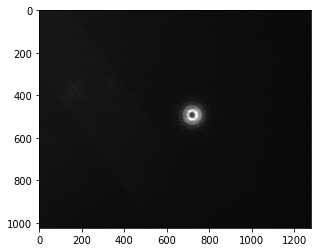

In [29]:
im = plt.imread('C:\\Users\\IFIc\\Desktop\\thorcam_screenshot\\size2_min.tif')
plt.imshow(im)

# Import image

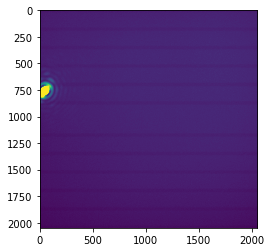

In [157]:
im = plt.imread('C:\\Users\\IFIc\\Documents\\Notebooks\\6.tiff')
plt.imshow(im)

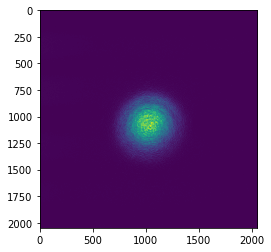

In [5]:
im = plt.imread('nolens_noiris_3cm.tiff')
plt.imshow(im)

# Autoselect ROI 

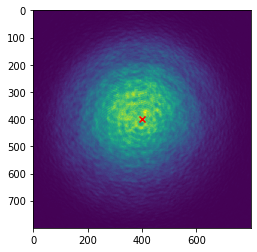

In [8]:
img = rgb2gray(im)
mx = guess_centroid(im)
bounds = bound_roi(im, mx, 400)
bounds

imroi = select_roi(im, bounds)

mxroi = guess_centroid(imroi)
pl = plt.imshow(imroi)#, cmap=plt.get_cmap('gray'))
plt.scatter(mx[1] - bounds[2], mx[0] - bounds[0], marker='x', color='r')

# Guess sigmas 

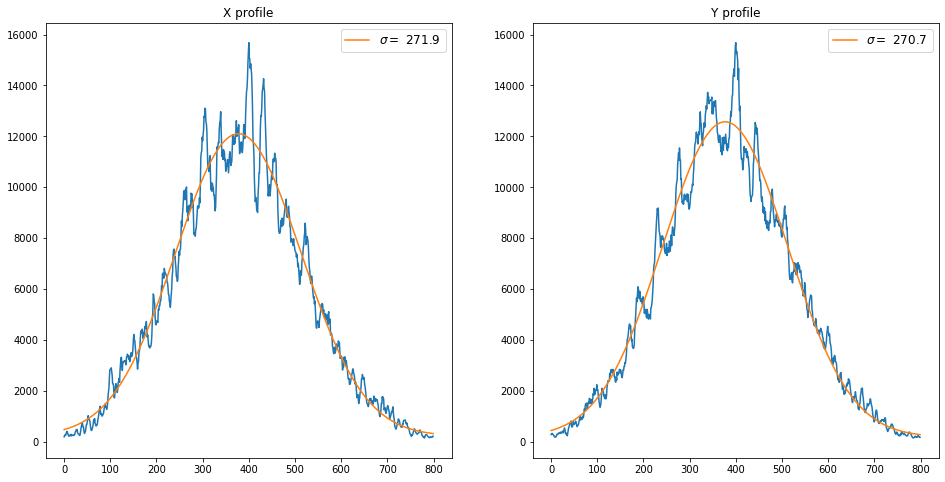

In [9]:
fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=True)
sigma_x = fitc[2]
sigma_y = fitr[2]

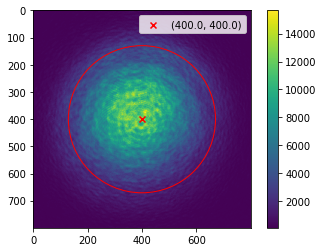

In [10]:
p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
plot_fit_result(imroi, p0)
plt.colorbar(pl)
plt.show()

# Fit to 2dGaussian

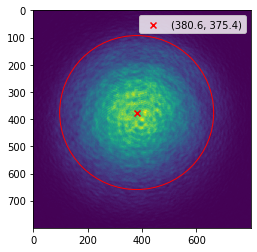

In [12]:
fit = fitGauss2d(imroi, p0 = p0, mode='ind')

pars = make_params(fit)
plot_fit_result(imroi, pars)

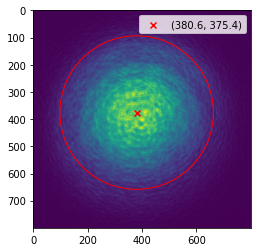

In [11]:
fit = fitGauss2d(imroi, p0 = p0, mode='waist')

pars = make_params(fit)
plot_fit_result(imroi, pars)

#  Zoom out of ROI

In [13]:
pars

[12283.183173427264,
 380.5841415029354,
 375.43979830614336,
 283.2345248472731,
 281.6299071366919,
 0.0035294818630092067]

In [14]:
pars

[12283.183173427264,
 380.5841415029354,
 375.43979830614336,
 283.2345248472731,
 281.6299071366919,
 0.0035294818630092067]

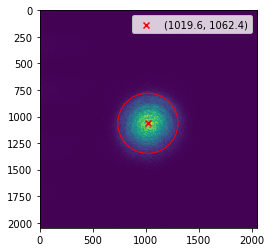

In [15]:
newp = zoom_out(pars, bounds)
plot_fit_result(im, newp)

# Rayleigh length:
$z_\mathrm{R} = \frac{\pi w_0^2 n}{\lambda}$


In [23]:
effective_size = 13.312 * mm
n_pix = 2048
pix_len = effective_size / n_pix 
pix_len / micron

6.5

In [25]:
w0 / mm

1.8410244115072754

In [68]:
np.sqrt(13.312**2 / 2048**2)

0.0065

In [22]:
w02 / micron2
np.sqrt(w02) / micron

722.1091845597131

In [21]:
#from invisible_cities.core.system_of_units import nm, mm, micron, micron2
nm = 1e-6
mm = 1
micron = 1e-3
micron2 = micron**2

wl = 520 * nm  # wave length
n = 1 # refraction index (air)

px_len = 6.5 * micron
#px_size = 6.5 * micron2
w0 = newp[3] * px_len
#w02 = newp[3]**2 * px_size

zr = np.pi*w0**2*n/ wl
#zr = np.pi*w02*n/ wl

zr / mm

20476.96667063365

## Pinhole size 

In [20]:
f = 40 * mm
ph = wl*f/w0
ph / mm

NameError: name 'w0' is not defined

# Define overall function 

In [16]:
def fit2dGauss(im : np.ndarray, DEBUG : bool = False, flag_p : bool = True) :
    """Fit 2d gaussian to an RGB image, perform ROI selection, parameter setting
    DEBUG flag shows whole process, flag_p shows final result"""
#     img = rgb2gray(im)
    mx = guess_centroid(im)
    bounds = bound_roi(im, mx, 500)
    imroi = select_roi(im, bounds)

    mxroi = guess_centroid(imroi)
    flp = False
    if DEBUG:
        flp = True
        pl = plt.imshow(imroi)#, cmap=plt.get_cmap('gray'))
        plt.scatter(mx[1] - bounds[2], mx[0] - bounds[0], marker='x', color='r')

    # Guess sigmas 

    fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=flp)
    sigma_x = fitc[2]
    sigma_y = fitr[2]

    p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
    if DEBUG:
        plot_fit_result(imroi, p0)
        plt.title('Initial parameter guess')

    # Fit to 2dGaussian

    fit = fitGauss2d(imroi, p0 = p0)

    pars = make_params(fit)
    if DEBUG:
        plot_fit_result(imroi, pars)
        plt.title('Fit result')

    #  Zoom out of ROI

    newp = zoom_out(pars, bounds)
    if flag_p:
        plot_fit_result(im, newp)
        plt.title('Fit result zoomed out')
    return newp

[34983.233359613514,
 1140.9845985890574,
 995.4665652241704,
 19.28014534441549,
 18.256445607946997,
 0.23323611803250643]

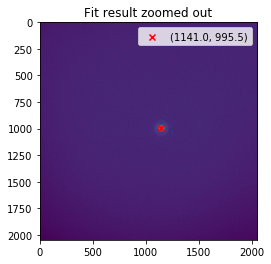

In [17]:
fit2dGauss(im)

# Apply on whole set 

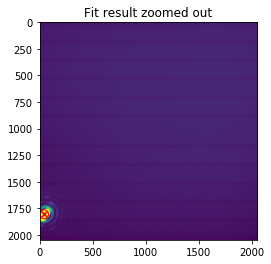

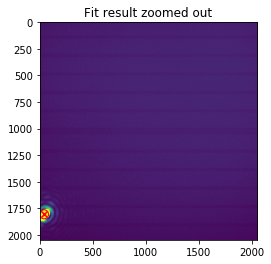

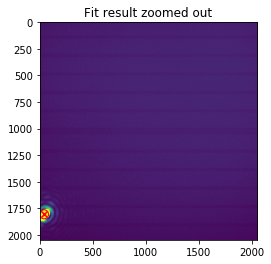

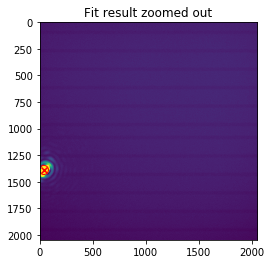

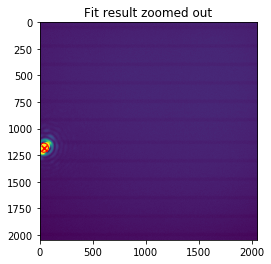

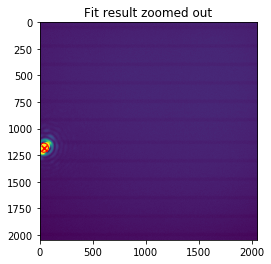

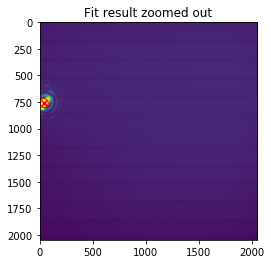

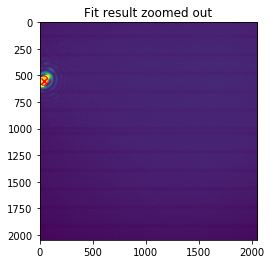

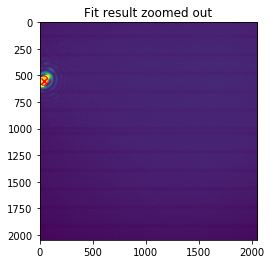

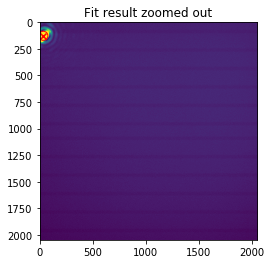

In [328]:
import glob
files = glob.glob('C:\\Users\\IFIc\\Documents\\Notebooks\\*.tiff')
fits = []
for f in files:
    im = plt.imread(f)
    fits.append(fit2dGauss(im))

In [326]:
[[f[1], f[2]] for f in fits]

[[41.77722046531331, 1807.061610219946],
 [41.67808076156351, 1807.2208903941437],
 [41.67808076156351, 1807.2208903941437],
 [40.401604794247284, 1389.462988257601],
 [40.11359154119445, 1179.8964516444423],
 [40.11359154119445, 1179.8964516444423],
 [38.94425673500004, 759.4104871538105],
 [37.38974738107637, 547.9628610103382],
 [37.38974738107637, 547.9628610103382],
 [35.05013067154063, 126.05107263744482]]

##### So we have a horizontal misalignment of 6 pixels